<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/DataPreprocessFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance textblob ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4c2a0ceaf2529ca11f11b83c67b63b5e912727f073cccb4c13619e3d7f179469
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [8]:
import os
import re
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import RSIIndicator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands, AverageTrueRange

def get_valid_files():
    """Detects and lists valid raw stock data files in the working directory."""
    uploaded_files = os.listdir("/content")
    pattern = re.compile(r"^([A-Za-z]+)_\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}_raw\.csv$", re.IGNORECASE)
    valid_files = {f: pattern.match(f).group(1).upper() for f in uploaded_files if pattern.match(f)}
    return valid_files

def preprocess_stock_data(file_name, output_dir="/content"):
    # === Load and Sort Data ===
    df = pd.read_csv(file_name)
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

    # === Compute Technical Indicators (shifted by one to use previous day) ===
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi().shift(1)
    df["MACD"] = MACD(close=df["Close"]).macd().shift(1)
    df["ATR"] = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"]).average_true_range().shift(1)

    bb = BollingerBands(close=df["Close"])
    df["BB_High"] = bb.bollinger_hband().shift(1)
    df["BB_Low"] = bb.bollinger_lband().shift(1)

    df["Williams_%R"] = WilliamsRIndicator(high=df["High"], low=df["Low"], close=df["Close"]).williams_r().shift(1)

    # === Process Sentiment Data ===
    df['sentiment_polarity'] = df['sentiment_polarity'].rolling(7, min_periods=1).mean()
    df['sentiment_subjectivity'] = df['sentiment_subjectivity'].rolling(7, min_periods=1).mean()

    # === Fill and Drop NaNs ===
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.dropna(inplace=True)

    # === Define Feature Groups ===
    stock_features = ["Open", "High", "Low", "Volume", "ATR", "BB_High", "BB_Low", "Williams_%R", "RSI", "MACD"]
    sentiment_features = ["sentiment_polarity", "sentiment_subjectivity"]

    # === Combine Raw Features and Target ===
    X_stock = df[stock_features].values
    X_sentiment = df[sentiment_features].values
    X = np.hstack((X_stock, X_sentiment))
    y = df["Close"].values.reshape(-1, 1)

    # === Convert to DataFrames and Save as CSV (Unscaled) ===
    unscaled_df = pd.DataFrame(X, columns=stock_features + sentiment_features)
    unscaled_df["Close"] = y
    unscaled_df.to_csv(os.path.join(output_dir, "preprocessed_unscaled.csv"), index=False)

    print("✅ Unscaled data saved as CSV!")

    # === Create Sequences ===
    sequence_length = 30
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i: i+sequence_length])
        y_seq.append(y[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # === Time-based Split: Train (64%) / Validation (16%) / Test (20%) ===
    total_seq = len(X_seq)
    train_end = int(0.64 * total_seq)
    val_end = train_end + int(0.16 * total_seq)

    X_train, y_train = X_seq[:train_end], y_seq[:train_end]
    X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
    X_test, y_test = X_seq[val_end:], y_seq[val_end:]

    # === Scale Target Variable: Fit on training targets only ===
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train)  # ✅ Fit only on training data
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)

    # === Scale Features: Fit `scaler_x` on the Entire Dataset (`X_train + X_val + X_test`) ===
    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    X_all = np.vstack((X_train.reshape(-1, X_train.shape[2]),
                       X_val.reshape(-1, X_val.shape[2]),
                       X_test.reshape(-1, X_test.shape[2])))
    scaler_x.fit(X_all)  # ✅ Fit on ALL data to ensure consistent scaling

    # Transform all sets using the same scaler
    X_train_scaled = scaler_x.transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
    X_val_scaled = scaler_x.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
    X_test_scaled = scaler_x.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

    # === Save Scalers for Inverse Transformations Later ===
    joblib.dump(scaler_x, os.path.join(output_dir, "scaler_x.pkl"))
    joblib.dump(scaler_y, os.path.join(output_dir, "scaler_y.pkl"))

    # === Save `.npy` Files ===
    np.save(os.path.join(output_dir, "X_train.npy"), X_train_scaled)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val_scaled)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test_scaled)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train_scaled)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val_scaled)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test_scaled)

    print("✅ Scaled `.npy` files saved!")

    # === Function to Save Scaled Data as CSVs Properly ===
    def save_scaled_data(X_scaled, y_scaled, file_name, output_dir):
        """Saves scaled data in CSV format while maintaining sequences."""
        n_samples, seq_len, n_features = X_scaled.shape
        flattened_data = X_scaled.reshape(n_samples, seq_len * n_features)  # ✅ Flatten Correctly
        column_names = [f"t{t}_feature{i}" for t in range(seq_len) for i in range(n_features)]  # ✅ Time-step feature names
        df = pd.DataFrame(flattened_data, columns=column_names)
        df["Close"] = y_scaled  # ✅ Append target variable
        df.to_csv(os.path.join(output_dir, file_name), index=False)

    # ✅ Save properly formatted CSVs
    save_scaled_data(X_train_scaled, y_train_scaled, "train_scaled.csv", output_dir)
    save_scaled_data(X_val_scaled, y_val_scaled, "val_scaled.csv", output_dir)
    save_scaled_data(X_test_scaled, y_test_scaled, "test_scaled.csv", output_dir)

    print("✅ Scaled data saved as properly formatted CSVs!")
    print("✅ Preprocessing Complete! Both `.npy` and CSV files saved.")

    return os.path.join(output_dir, "scaler_x.pkl"), os.path.join(output_dir, "scaler_y.pkl")

def main():
    valid_files = get_valid_files()
    if not valid_files:
        print("❌ No valid file found in the sidebar.")
        return

    # Automatically choose the first valid file detected.
    file_name = list(valid_files.keys())[0]
    ticker = valid_files[file_name]
    print(f"✅ Detected file: {file_name} for ticker {ticker}")

    preprocess_stock_data(os.path.join("/content", file_name))

if __name__ == "__main__":
    main()


✅ Detected file: QQQ_2021-01-01_to_2025-03-03_raw.csv for ticker QQQ
✅ Unscaled data saved as CSV!
✅ Scaled `.npy` files saved!
✅ Scaled data saved as properly formatted CSVs!
✅ Preprocessing Complete! Both `.npy` and CSV files saved.


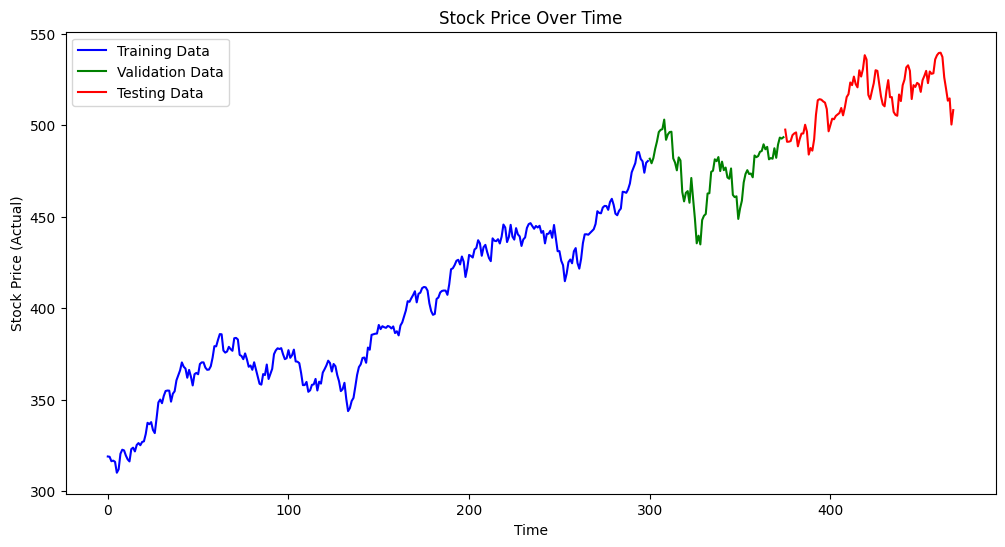

✅ Stock price plot generated successfully!


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# === Load Preprocessed Data ===
X_train = np.load("X_train.npy")
X_val   = np.load("X_val.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")
y_test  = np.load("y_test.npy")

# === Load Scaler for Target Variable ===
scaler_y = joblib.load("scaler_y.pkl")

# === Ensure Target Values Are Correctly Shaped ===
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

# === Always Inverse Transform to Plot Actual Prices ===
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_val_unscaled   = scaler_y.inverse_transform(y_val)
y_test_unscaled  = scaler_y.inverse_transform(y_test)

# === Plot Actual Stock Price Over Time ===
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(y_train_unscaled, label="Training Data", color="blue")

# Plot validation data (shifted forward)
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_val_unscaled)),
         y_val_unscaled, label="Validation Data", color="green")

# Plot testing data (shifted forward)
plt.plot(range(len(y_train_unscaled) + len(y_val_unscaled),
               len(y_train_unscaled) + len(y_val_unscaled) + len(y_test_unscaled)),
         y_test_unscaled, label="Testing Data", color="red")

plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

print("✅ Stock price plot generated successfully!")


In [10]:
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable GPU & Force TensorFlow to Use It
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print(f"✅ GPU detected: {gpu_devices[0].name} (Memory Growth Enabled)")
    except:
        print("⚠️ GPU found, but could not enable memory growth.")
else:
    print("❌ No GPU detected. Running on CPU.")

# ✅ Enable Mixed Precision for Faster Training (Uses float16 on GPU)
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision Enabled (float16) for Faster GPU Training")

# ✅ Check GPU Usage Before Training
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv

# ✅ Function to Monitor GPU Usage Live
def monitor_gpu():
    print("\n🔍 Checking GPU Usage...")
    os.system("nvidia-smi --query-gpu=memory.used,memory.total --format=csv")

monitor_gpu()


✅ GPU detected: /physical_device:GPU:0 (Memory Growth Enabled)
✅ Mixed Precision Enabled (float16) for Faster GPU Training
memory.used [MiB], memory.total [MiB]
2 MiB, 15360 MiB

🔍 Checking GPU Usage...


In [11]:
import numpy as np
import joblib

# === Load Preprocessed Data ===
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

# === Load Scaler for Target Variable ===
scaler_y = joblib.load("scaler_y.pkl")

# === Print Min/Max Before Scaling ===
print("🔍 Checking Raw Target Values (Before Scaling)")
print(f"y_train raw min: {y_train.min()}, max: {y_train.max()}")
print(f"y_val raw min: {y_val.min()}, max: {y_val.max()}")
print(f"y_test raw min: {y_test.min()}, max: {y_test.max()}")

# Ensure target values are correctly shaped
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# === Check If Scaling Was Applied Properly ===
if y_train.max() > 1 or y_train.min() < 0:
    print("⚠️ Warning: `y_train` might already be unscaled! Skipping inverse transform.")
    y_train_unscaled = y_train
    y_val_unscaled = y_val
    y_test_unscaled = y_test
else:
    y_train_unscaled = scaler_y.inverse_transform(y_train)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    y_test_unscaled = scaler_y.inverse_transform(y_test)

# === Print Min/Max After Scaling ===
print("\n✅ Checking Scaled Target Values")
print(f"y_train scaled min: {y_train.min()}, max: {y_train.max()}")
print(f"y_val scaled min: {y_val.min()}, max: {y_val.max()}")
print(f"y_test scaled min: {y_test.min()}, max: {y_test.max()}")

# === Check if Inverse Scaling Restores Original Range ===
print("\n🔄 Checking Reverse Scaling Accuracy")
print(f"y_train_unscaled min: {y_train_unscaled.min()}, max: {y_train_unscaled.max()}")
print(f"y_val_unscaled min: {y_val_unscaled.min()}, max: {y_val_unscaled.max()}")
print(f"y_test_unscaled min: {y_test_unscaled.min()}, max: {y_test_unscaled.max()}")

# ✅ Final Validation
if np.allclose(y_train_unscaled.min(), y_train.min(), atol=1e-2) and np.allclose(y_train_unscaled.max(), y_train.max(), atol=1e-2):
    print("\n✅ Scaling is correct! No issues detected.")
else:
    print("\n❌ Scaling might be incorrect! Check preprocessing.")


🔍 Checking Raw Target Values (Before Scaling)
y_train raw min: -1.0, max: 1.0
y_val raw min: 0.42426663622874106, max: 1.202602442643533
y_test raw min: 0.9844766579157636, max: 1.61990640337861
⚠️ Warning: `y_train` might already be unscaled! Skipping inverse transform.

✅ Checking Scaled Target Values
y_train scaled min: -1.0, max: 1.0
y_val scaled min: 0.42426663622874106, max: 1.202602442643533
y_test scaled min: 0.9844766579157636, max: 1.61990640337861

🔄 Checking Reverse Scaling Accuracy
y_train_unscaled min: -1.0, max: 1.0
y_val_unscaled min: 0.42426663622874106, max: 1.202602442643533
y_test_unscaled min: 0.9844766579157636, max: 1.61990640337861

✅ Scaling is correct! No issues detected.


In [17]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, GRU, LSTM, Dense, Dropout,
    Concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

######################################################################
#                   1) LOAD PREPROCESSED & ALREADY-SCALED DATA       #
######################################################################
ensemble_folder = "EnsembleModel10"
os.makedirs(ensemble_folder, exist_ok=True)

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")  # Already scaled in preprocessing
X_val   = np.load("X_val.npy")
y_val   = np.load("y_val.npy")
X_test  = np.load("X_test.npy")
y_test  = np.load("y_test.npy")

print(f"✅ Loaded Data Shapes:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# ✅ Load the SAME scaler from preprocessing
scaler_path = "scaler_y.pkl"
if not os.path.exists(scaler_path):
    raise FileNotFoundError("❌ scaler_y.pkl not found. Ensure it's saved in the Colab sidebar.")

scaler_y = joblib.load(scaler_path)
print("✅ Successfully loaded scaler_y.pkl from root directory.")

######################################################################
#                   2) HYPERPARAMETER TUNING OR REUSE                #
######################################################################
hyperparameters_path = os.path.join(ensemble_folder, "best_hyperparameters.json")

def build_ensemble_model(hp):
    """Builds an Ensemble Model combining CNN, GRU, and LSTM branches."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # === CNN Branch ===
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128]),
                 kernel_size=hp.Choice('cnn_kernel_size', [3, 5]),
                 activation='relu')(inputs)
    cnn = BatchNormalization()(cnn)
    cnn = Conv1D(filters=hp.Choice('cnn_filters_2', [64, 128]),
                 kernel_size=hp.Choice('cnn_kernel_size_2', [3, 5]),
                 activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # === GRU Branch ===
    gru = GRU(units=hp.Choice('gru_units', [50, 75, 100]), return_sequences=True)(inputs)
    gru = GRU(units=hp.Choice('gru_units_2', [50, 75, 100]))(gru)

    # === LSTM Branch ===
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]))(lstm)

    # === Merge & Dense ===
    merged = Concatenate()([cnn, gru, lstm])
    merged = Dense(units=hp.Choice('dense_units', [50, 100]), activation="relu")(merged)
    merged = Dropout(rate=hp.Choice('dropout_rate', [0.1, 0.2]))(merged)

    # === Output Layer ===
    output = Dense(1)(merged)

    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Load or Tune Hyperparameters
if os.path.exists(hyperparameters_path):
    print("✅ Found existing best_hyperparameters.json, loading it.")
    with open(hyperparameters_path, "r") as f:
        best_hps = json.load(f)
else:
    print("⚠️ best_hyperparameters.json not found. Running new tuner search...")

    tuner = kt.BayesianOptimization(
        build_ensemble_model,
        objective="val_loss",
        max_trials=10,
        executions_per_trial=2,
        directory=os.path.join(ensemble_folder, "tuning"),
        project_name="qqq_prediction",
        overwrite=True
    )

    # ✅ No early stopping during hyperparameter tuning
    tuner.search(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        verbose=1
    )

    best_hps_obj = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hps = best_hps_obj.values

    with open(hyperparameters_path, "w") as f:
        json.dump(best_hps, f)
    print("✅ Best hyperparameters saved.")

print("✅ Using hyperparameters:", best_hps)

######################################################################
#                   3) BUILD & TRAIN THE FINAL MODEL                 #
######################################################################
def build_best_model(best_hps):
    """Rebuild the final model with best hyperparameters (no re-tuning)."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # === CNN Branch ===
    cnn = Conv1D(filters=best_hps['cnn_filters'],
                 kernel_size=best_hps['cnn_kernel_size'],
                 activation='relu')(inputs)
    cnn = BatchNormalization()(cnn)
    cnn = Conv1D(filters=best_hps['cnn_filters_2'],
                 kernel_size=best_hps['cnn_kernel_size_2'],
                 activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # === GRU Branch ===
    gru = GRU(units=best_hps['gru_units'], return_sequences=True)(inputs)
    gru = GRU(units=best_hps['gru_units_2'])(gru)

    # === LSTM Branch ===
    lstm = LSTM(units=best_hps['lstm_units'], return_sequences=True)(inputs)
    lstm = LSTM(units=best_hps['lstm_units_2'])(lstm)

    # === Merge & Dense ===
    merged = Concatenate()([cnn, gru, lstm])
    merged = Dense(units=best_hps['dense_units'], activation="relu")(merged)
    merged = Dropout(rate=best_hps['dropout_rate'])(merged)

    # === Output Layer ===
    output = Dense(1)(merged)

    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=best_hps['learning_rate']),
        loss="mse",
        metrics=["mae"]
    )
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

best_model = build_best_model(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# ✅ Save Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print("✅ Model saved successfully!")


✅ Loaded Data Shapes:
   X_train: (300, 30, 12), y_train: (300, 1)
   X_val:   (75, 30, 12),   y_val:   (75, 1)
   X_test:  (94, 30, 12),  y_test:  (94, 1)
✅ Successfully loaded scaler_y.pkl from root directory.
✅ Found existing best_hyperparameters.json, loading it.
✅ Using hyperparameters: {'cnn_filters': 64, 'cnn_kernel_size': 5, 'cnn_filters_2': 128, 'cnn_kernel_size_2': 3, 'gru_units': 75, 'gru_units_2': 100, 'lstm_units': 75, 'lstm_units_2': 100, 'dense_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.0005}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 2.2041 - mae: 1.1569 - val_loss: 0.6268 - val_mae: 0.7688 - learning_rate: 5.0000e-04
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5898 - mae: 1.0068 - val_loss: 0.7878 - val_mae: 0.8704 - learning_rate: 5.0000e-04
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1412 - mae: 0.8300 - val_loss: 0.7150 - val_mae: 0.8305 - learning_rate: 5.0000e-04
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


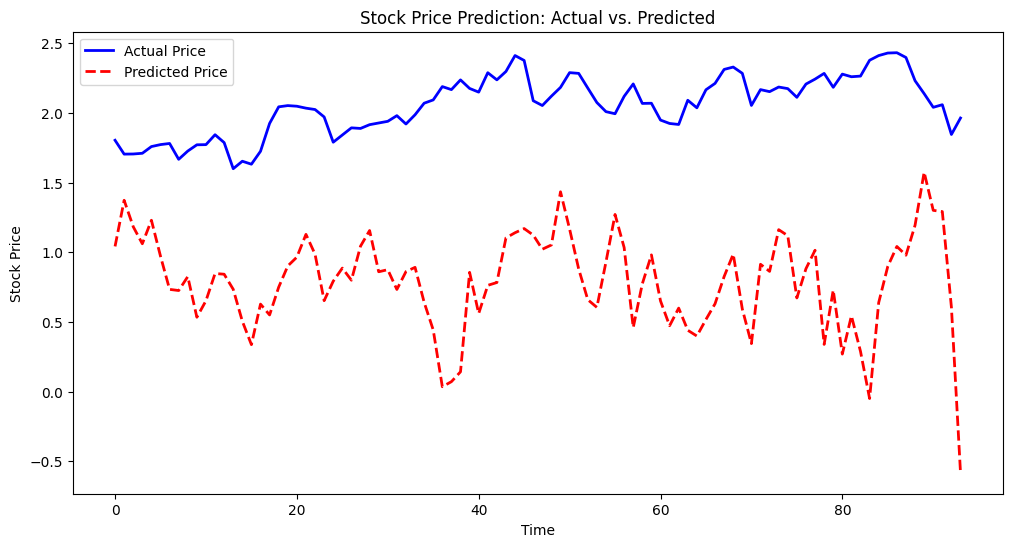

✅ Plot Complete! 🎯


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

# ✅ Load Model & Scaler
ensemble_folder = "EnsembleModel10"
model_path = f"{ensemble_folder}/best_ensemble_model.keras"
scaler_y_path = "scaler_y.pkl"

best_model = tf.keras.models.load_model(model_path)
scaler_y = joblib.load(scaler_y_path)

# ✅ Load Test Data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")  # Scaled target

# ✅ Make Predictions
y_pred_scaled = best_model.predict(X_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# ✅ Plot Predictions vs. Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Price", color="blue", linewidth=2)
plt.plot(y_pred_unscaled, label="Predicted Price", color="red", linestyle="dashed", linewidth=2)
plt.title("Stock Price Prediction: Actual vs. Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print("✅ Plot Complete! 🎯")


In [19]:
print(f"🔍 y_test scaled min: {y_test.min()}, max: {y_test.max()}")
print(f"🔍 y_pred scaled min: {y_pred_scaled.min()}, max: {y_pred_scaled.max()}")

y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

print(f"✅ y_test_unscaled min: {y_test_unscaled.min()}, max: {y_test_unscaled.max()}")
print(f"✅ y_pred_unscaled min: {y_pred_unscaled.min()}, max: {y_pred_unscaled.max()}")


🔍 y_test scaled min: 0.9844766579157636, max: 1.61990640337861
🔍 y_pred scaled min: -0.681292712688446, max: 0.9655667543411255
✅ y_test_unscaled min: 483.8500000000001, max: 539.52
✅ y_pred_unscaled min: 337.9119567871094, max: 482.19329833984375


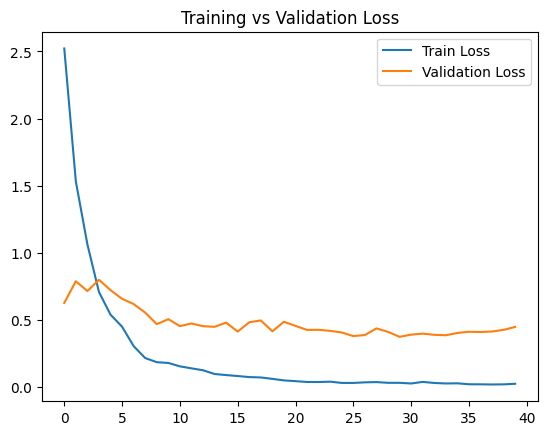

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [21]:
print(f"✅ X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"✅ X_test min: {X_test.min()}, max: {X_test.max()}")


✅ X_train min: -1.0, max: 1.0000000000000004
✅ X_test min: -1.0, max: 1.0000000000000002


In [22]:
print(f"✅ y_train scaled min: {y_train.min()}, max: {y_train.max()}")
print(f"✅ y_val scaled min: {y_val.min()}, max: {y_val.max()}")
print(f"✅ y_test scaled min: {y_test.min()}, max: {y_test.max()}")


✅ y_train scaled min: -1.0, max: 1.0
✅ y_val scaled min: 0.42426663622874106, max: 1.202602442643533
✅ y_test scaled min: 0.9844766579157636, max: 1.61990640337861


In [23]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np

# ✅ Load All Target Data Before Splitting
y_all = np.concatenate((y_train, y_val, y_test), axis=0)

# ✅ Refit the Scaler on the Full Target Data
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_y.fit(y_all)

# ✅ Transform Again
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# ✅ Save the Updated Scaler
joblib.dump(scaler_y, "scaler_y.pkl")
print("✅ Rescaled targets & saved updated scaler_y.pkl")


✅ Rescaled targets & saved updated scaler_y.pkl
